In [1]:
import numpy as np
import scipy.linalg as splin
from scipy.integrate import LSODA, solve_ivp
import matplotlib.pyplot as plt

from consts import *
from lyapunov import *
from pac import *
from potential import *
from utils import *
from lyap_obj import *

In [2]:
# Initial conditions (alpha0) and Jacobi interval
alpha0 = 50/384400 # initial guess for alpha

# C = 2U(r) - (vx^2 + vy^2)
C_range = [3.1370, 3.1493]

In [3]:
fL1 = Family(XL1, mu)
fL1.find_family(alpha0, 40)

In [4]:
fL2 = Family(XL2, mu)
fL2.find_family(alpha0, 40)

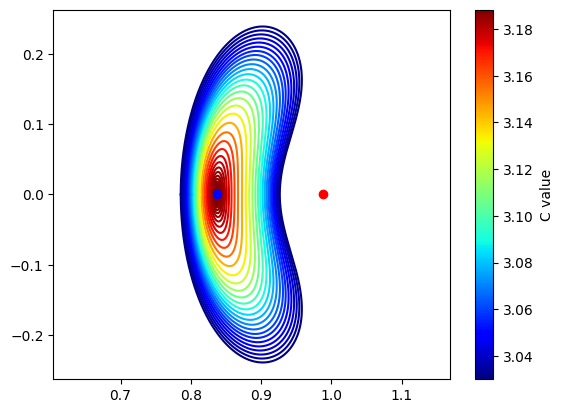

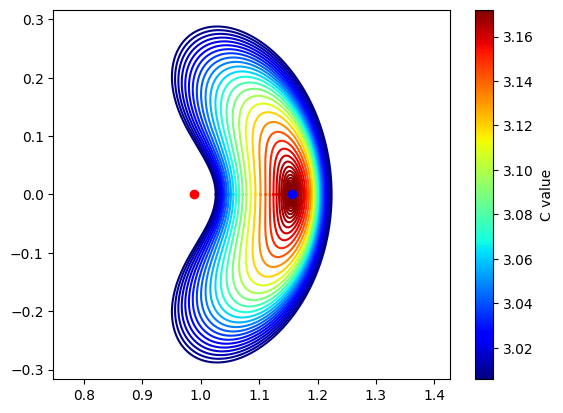

In [5]:
fL1.plot_family()
fL2.plot_family()

In [6]:
# Obtain two orbits in [C_range[0]  C_range[1]] in L1
orbsL1 = find_Crange(fL1, 2, C_range, verbose=True)

Found 1 orbits in the range, PACing to find more
Found orbit 1
ds: 0.01, C_guess: 3.1422696744783094, G_guess: 5.748861366033244e-13


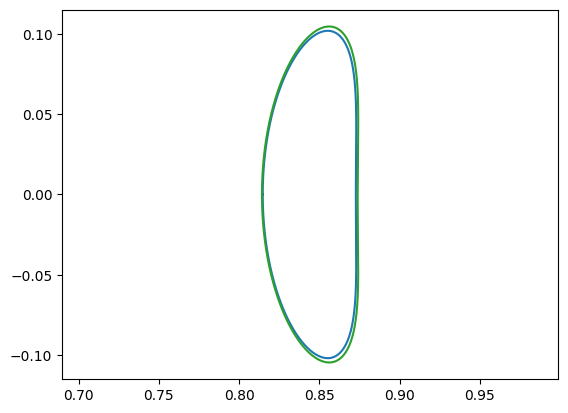

In [7]:
for orbit in orbsL1:
    orbit.plot()
plt.axis('equal')
plt.show()

In [8]:
# Find isoenergetic L2 orbits
isoC_L2 = []
for oL1 in orbsL1:
    isoC_L2.append(find_isoC(oL1, fL2, verbose=True)) 

Finding orbits with C = 3.144399216220354
Orbit not in the C tolerance. C = 3.143319659964456, err = 0.001079556255898062, ds = -0.02904363630642024, G = 7.938626928465207e-13
Orbit not in the C tolerance. C = 3.149319324815042, err = 0.004920108594688166, ds = 0.026403305733109308, G = 7.81399476950256e-13
Orbit not in the C tolerance. C = 3.143834479639465, err = 0.0005647365808889582, ds = -0.02400300521191755, G = 9.746809136537764e-13
Orbit not in the C tolerance. C = 3.1487985219466297, err = 0.004399305726275671, ds = 0.021820913829015954, G = 9.892796322703889e-13
Orbit not in the C tolerance. C = 3.1442650029545867, err = 0.0001342132657673467, ds = -0.019837194390014502, G = 8.105413370671067e-13
Orbit not in the C tolerance. C = 3.14837099293151, err = 0.003971776711155783, ds = 0.018033813081831364, G = 8.236274590542006e-13
Orbit not in the C tolerance. C = 3.144624193000313, err = 0.00022497677995891863, ds = 0.0163943755289376, G = 9.269262580273303e-13
Orbit not in the 